In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from joblib import load,dump
import tensorflow as tf
import tensorflow_hub as hub
from IPython.display import Image
import datetime


%matplotlib inline

In [ ]:
# Checkout the labels of our data

labels_csv = pd.read_csv("/content/drive/MyDrive/machine_learning/Dog_vision_project/labels.csv")

print(labels_csv.describe())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     32892307155e3ce2348f6803c7c908de  scottish_deerhound
freq                                   1                 126


In [ ]:
labels = labels_csv["breed"].to_numpy() # Transform data into numpy array
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [ ]:
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [ ]:
# Create a simple function to return a tuple of tensors (image, label)
def get_image_label(image_path,label):
  """
  Takes an image path name and the associated label,
  process the image and returns a type of (image,label) 
  """
  image = process_image(image_path)
  return image,label

In [ ]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images

def process_image(image_path,img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image
  into a Tensor
  sets max image size to 224, 224
  """
  image = tf.io.read_file(image_path)
  # Turn the jpg image into a numerical Tensor with 3 color channels (RGB)
  image = tf.image.decode_jpeg(image,channels=3)
  # Convert the color channel values from 0-255 to 0-1 values
  # Normalizing the image (converting from 0-255 to 0-1) makes the computing much faster
  image = tf.image.convert_image_dtype(image,tf.float32)
  # Resize the image to our desired value (224,224)
  image = tf.image.resize(image,size=[img_size,img_size])

  return image

In [ ]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Creates batches of data out of image (X) and label (y) pairs.
  Shuffles the data if it's training data but doesn't shuffle if it's validation data.
  Also accepts test data as input (no labels).
  """
  # If the data is a test dataset, we probably don't have have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # only filepaths (no labels)
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch
  
  # If the data is a valid dataset, we don't need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) # labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function is faster than shuffling images
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the iamge path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [ ]:
def unbatch_data(data):
  """
  Takes a batched data set of (images,labels) Tensors and
  returns separate arrays of images and labels
  """
  images = []
  labels = []

  for image , label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_breeds[np.argmax(label)])
  return images,labels

In [ ]:
def get_pred_label(prediction_probabilities):
  """
  Turns an array of prediciton probabilities into
  a label.
  """
  return unique_breeds[np.argmax(prediction_probabilities)]

In [ ]:
# Create a function to load a trained model
def load_model(model_path):
  """
  Loads a saved model from a specified path.
  """
  print(f"Loading saved model from: {model_path}")
  model = tf.keras.models.load_model(model_path,
                                     custom_objects={"KerasLayer":hub.KerasLayer})
  return model

In [ ]:
import os

custom_path = "/content/drive/MyDrive/machine_learning/Dog_vision_project/extra-dog-photos/"

custom_image_paths = [custom_path +fname for fname in os.listdir(custom_path)]
custom_image_paths

['/content/drive/MyDrive/machine_learning/Dog_vision_project/extra-dog-photos/IMG_20190729_100720.jpg',
 '/content/drive/MyDrive/machine_learning/Dog_vision_project/extra-dog-photos/IMG_20190729_102441.jpeg',
 '/content/drive/MyDrive/machine_learning/Dog_vision_project/extra-dog-photos/IMG_20191226_153630.jpg',
 '/content/drive/MyDrive/machine_learning/Dog_vision_project/extra-dog-photos/dog-photo-2.jpeg',
 '/content/drive/MyDrive/machine_learning/Dog_vision_project/extra-dog-photos/external-content.duckduckgo.com.jpg',
 '/content/drive/MyDrive/machine_learning/Dog_vision_project/extra-dog-photos/sausage_dog.jpg',
 '/content/drive/MyDrive/machine_learning/Dog_vision_project/extra-dog-photos/159355687_359985948467655_2575479924754455860_n.jpg',
 '/content/drive/MyDrive/machine_learning/Dog_vision_project/extra-dog-photos/159723744_501964380971724_5874371106344625077_n.jpg',
 '/content/drive/MyDrive/machine_learning/Dog_vision_project/extra-dog-photos/rtc-snapshot-6238375198075423030.jpe

In [ ]:
custom_data = create_data_batches(custom_image_paths, test_data=True)
custom_data

Creating test data batches...


<BatchDataset shapes: (None, 224, 224, 3), types: tf.float32>

In [ ]:
# Load the full model
loaded_full_model = load_model("/content/drive/MyDrive/machine_learning/Dog_vision_project/models/20210128-21341611869694-full-image-set-mobilenetV2-Adam.h5")


Loading saved model from: /content/drive/MyDrive/machine_learning/Dog_vision_project/models/20210128-21341611869694-full-image-set-mobilenetV2-Adam.h5


In [ ]:
# Make predictions on the custom data
%%time 
custom_preds = loaded_full_model.predict(custom_data)
#custom_preds

CPU times: user 3.26 s, sys: 1.44 s, total: 4.71 s
Wall time: 35.5 s


In [ ]:
custom_preds.shape

(10, 120)

In [ ]:
# Get custom image prediction labels
custom_pred_labels = [get_pred_label(custom_preds[i]) for i in range(len(custom_preds))]
custom_pred_labels

['german_shepherd',
 'border_terrier',
 'german_shepherd',
 'lakeland_terrier',
 'border_collie',
 'black-and-tan_coonhound',
 'greater_swiss_mountain_dog',
 'maltese_dog',
 'pug',
 'siberian_husky']

In [ ]:
# Get custom images (unbatch function wont work since there are no labels)
custom_images = []

# Loop through unbatched data
for image in custom_data.unbatch().as_numpy_iterator():
  custom_images.append(image)

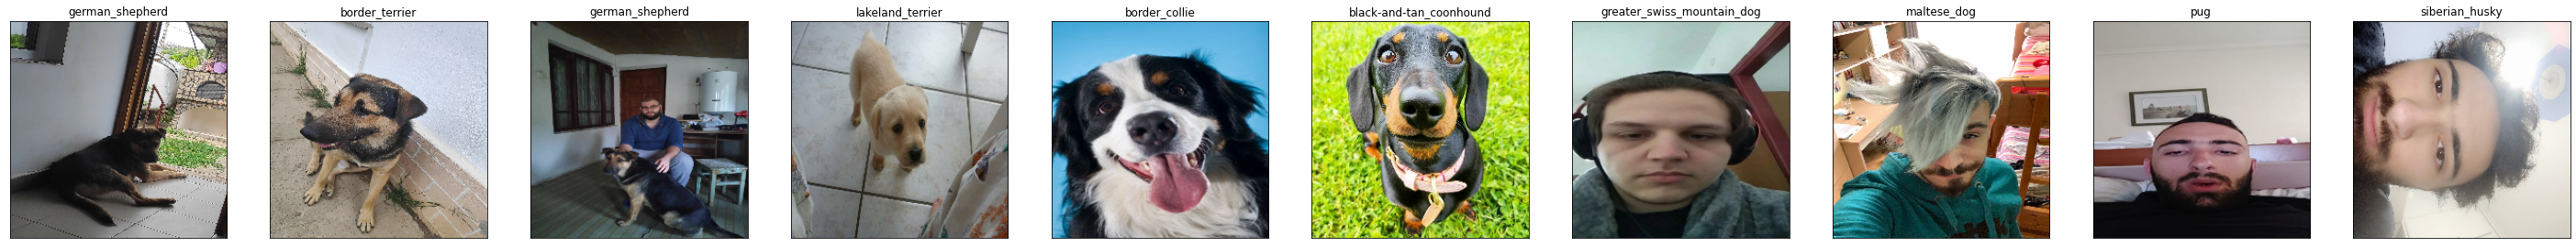

In [ ]:
# Check custom image predictions
plt.figure(figsize=(50,50))
for i, image in enumerate(custom_images):
  plt.subplot(1, len(custom_images), i+1)
  plt.xticks([])
  plt.yticks([])
  plt.title(custom_pred_labels[i])
  plt.imshow(image)